In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("datas/movies_metadata.csv")

C:\Users\meule\AppData\Local\Temp\ipykernel_17140\3608718971.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("datas/movies_metadata.csv")


In [3]:
# Extract gender names from gender columns
import ast

# Convert string values to list of dictionaries
df.genres = df.genres.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract genre names
df.genres = df.genres.apply(lambda x: [genre['name'] for genre in x])

In [4]:
df = df[['title', 'genres','overview','tagline']]

In [5]:
df.head() 

,title,genres,overview,tagline
0,Toy Story,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",NaN
1,Jumanji,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!
2,Grumpier Old Men,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...
3,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...
4,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...


In [6]:
# Remove rows where genres list is empty

df = df[df["genres"].map(len)>0]
df.info
df.tail()

,title,genres,overview,tagline
45459,Caged Heat 3000,[Science Fiction],It's the year 3000 AD. The world's most danger...,NaN
45460,Robin Hood,"[Drama, Action, Romance]","Yet another version of the classic epic, with ...",NaN
45461,Subdue,"[Drama, Family]",Rising and falling between a man and woman.,Rising and falling between a man and woman
45462,Century of Birthing,[Drama],An artist struggles to finish his work while a...,NaN
45463,Betrayal,"[Action, Drama, Thriller]","When one of her hits goes wrong, a professiona...",A deadly game of wits.


In [7]:
# Clean Overview
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize

# Define stopwords and stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Clean text function
def clean_text(text):
    if type(text) == float:                     # change type to text for some plot in dataset
        text = str(text)
    text = text.lower()                         # Lowercase
    text = re.sub(r"(\b\w+)'s\b", r"\1", text)  # remove 's suffix
    text = re.sub("[^a-zA-Z'-]", " ", text)     # remove non-letter characters
    words = word_tokenize(text)
    words = [ps.stem(w) for w in words if w not in stop_words] # stem words
    return " ".join(words)

# Clean the overview column
df["clean_overview"] = df['overview'].apply(clean_text)

df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\meule\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meule\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,genres,overview,tagline,clean_overview
0,Toy Story,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",NaN,led woodi andi toy live happili room andi birt...
1,Jumanji,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,sibl judi peter discov enchant board game open...
2,Grumpier Old Men,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,famili wed reignit ancient feud next-door neig...
3,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,cheat mistreat step women hold breath wait elu...
4,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,georg bank recov daughter wed receiv news preg...


In [8]:
test_value = df.sample(1)
test_value

,title,genres,overview,tagline,clean_overview
12825,Felon,"[Action, Crime, Drama]",A family man convicted of killing an intruder ...,No rule. No hope. No way out.,famili man convict kill intrud must cope life ...


In [9]:
# List the genres to drop, too many in dataset
genres_counts = df.explode('genres')['genres'].value_counts()
genres_to_drop = genres_counts.loc[lambda g : g < 100].index.tolist()
genres_to_drop

['Carousel Productions',
 'Vision View Entertainment',
 'Telescene Film Group Productions',
 'Aniplex',
 'GoHands',
 'BROSTA TV',
 'Mardock Scramble Production Committee',
 'Sentai Filmworks',
 'Odyssey Media',
 'Pulser Productions',
 'Rogue State',
 'The Cartel']

In [10]:
mask = df['genres'].apply(lambda x: not any(item in genres_to_drop for item in x))

In [11]:
df = df[mask]
df.head()
df.shape

(43021, 5)

In [12]:
# Select 100 rows from df to test the model with
df = df.sample(n=200)

In [13]:
# Define target and features
X = df.clean_overview.tolist()

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df.genres)
mapping = {i: name for i, name in enumerate(mlb.classes_)}

In [14]:
mapping

{0: 'Action',
 1: 'Adventure',
 2: 'Animation',
 3: 'Comedy',
 4: 'Crime',
 5: 'Documentary',
 6: 'Drama',
 7: 'Family',
 8: 'Fantasy',
 9: 'Foreign',
 10: 'History',
 11: 'Horror',
 12: 'Music',
 13: 'Mystery',
 14: 'Romance',
 15: 'Science Fiction',
 16: 'TV Movie',
 17: 'Thriller',
 18: 'War',
 19: 'Western'}

In [15]:
from sklearn.model_selection import train_test_split
# Split Train and Validation data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

# Keep some data for inference (testing)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=0)

In [16]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
# convert the class_weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In [17]:
class_weights_dict

{0: 0.00012901622126967153,
 1: 0.004722657412532593,
 2: 0.002760947135170971,
 3: 0.0009402853927945526,
 4: 1.1010367597125907e-05,
 5: 1.1010367597125907e-05,
 6: 0.07211517795761799,
 7: 3.1526417974182855e-05,
 8: 0.002729570221578396,
 9: 0.00804641981789176,
 10: 0.017128800670920513,
 11: 0.00023562186657849441,
 12: 0.00012901622126967153,
 13: 0.0010158083586829865,
 14: 0.006377532744551247,
 15: 0.01255079142641447,
 16: 0.005251945343829059,
 17: 2.6358152732513544e-05,
 18: 7.707257317988138e-05,
 19: 0.0008429048082688615,
 20: 0.04263889648752727,
 21: 0.00013764813093645963,
 22: 3.1526417974182855e-05,
 23: 1.1010367597125907e-05,
 24: 0.0025876404990910953,
 25: 1.1010367597125907e-05,
 26: 0.09823082957902501,
 27: 0.004978859442145575,
 28: 5.389285192277417e-05,
 29: 0.00033662485068103185,
 30: 1.1010367597125907e-05,
 31: 0.00023265698327783058,
 32: 0.00022068492581928006,
 33: 7.707257317988138e-05,
 34: 7.707257317988135e-05,
 35: 0.00039946765053363356,
 36

In [18]:
import tensorflow as tf
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

c:\Users\meule\Desktop\imdb\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
train_encodings = tokenizer(X_train, max_length=200, truncation=True, padding=True)
val_encodings = tokenizer(X_val, max_length=200, truncation=True, padding=True)
test_encodings = tokenizer(X_test, max_length=200, truncation=True, padding=True)

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [21]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(mapping))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [22]:
OPTIMIZER =  tf.keras.optimizers.Adam(learning_rate=3e-5)
LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = ['accuracy']

model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,968,852
Trainable params: 66,968,852
Non-trainable params: 0
_________________________________________________________________


In [23]:
BATCH_SIZE = 8
EPOCHS = 5

In [24]:
history = model.fit(
    train_dataset.batch(BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_dataset.batch(BATCH_SIZE),
    class_weight=class_weights_dict
)

Epoch 1/5
14/14 [==============================] - 64s 3s/step - loss: 0.0137 - accuracy: 0.2232 - val_loss: 0.5989 - val_accuracy: 0.3125
Epoch 2/5
14/14 [==============================] - 42s 3s/step - loss: 0.0113 - accuracy: 0.2857 - val_loss: 0.5060 - val_accuracy: 0.3125
Epoch 3/5
14/14 [==============================] - 44s 3s/step - loss: 0.0091 - accuracy: 0.2857 - val_loss: 0.4343 - val_accuracy: 0.3125
Epoch 4/5
14/14 [==============================] - 44s 3s/step - loss: 0.0074 - accuracy: 0.2857 - val_loss: 0.3845 - val_accuracy: 0.3125
Epoch 5/5
14/14 [==============================] - 42s 3s/step - loss: 0.0060 - accuracy: 0.2857 - val_loss: 0.3537 - val_accuracy: 0.3125


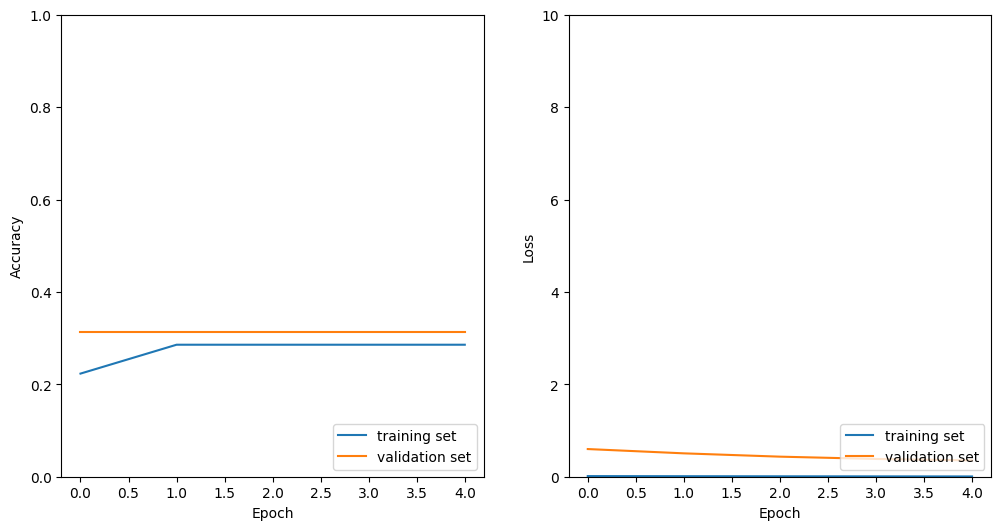

In [25]:
import tensorflow
from matplotlib import pyplot as plt

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [26]:
loss, accuracy = model.evaluate(test_dataset.batch(BATCH_SIZE))
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

5/5 [==============================] - 6s 626ms/step - loss: 0.3673 - accuracy: 0.2250
Loss: 0.36729320883750916
Accuracy: 0.22499999403953552


In [27]:
test_value

,title,genres,overview,tagline,clean_overview
12825,Felon,"[Action, Crime, Drama]",A family man convicted of killing an intruder ...,No rule. No hope. No way out.,famili man convict kill intrud must cope life ...


In [28]:
test_value.clean_overview.values[0]
test_value.genres.values[0]

['Action', 'Crime', 'Drama']

In [29]:

# Save the model and tokenizer to a directory
model.save_pretrained('./saved_model/')
tokenizer.save_pretrained('./saved_model/')

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [30]:
# # Load the saved model and tokenizer from a directory
# model = TFDistilBertForSequenceClassification.from_pretrained('./saved_model/')
# tokenizer = DistilBertTokenizer.from_pretrained('./saved_model/')

In [32]:
# text = "war crime "
text = test_value.clean_overview.values[0]
text = clean_text(text)
encodings = tokenizer([text], max_length=200, truncation=True, padding=True)
ds = tf.data.Dataset.from_tensor_slices(dict(encodings))
predictions = model.predict(ds)

import numpy as np
print(mapping[np.argmax(predictions[0])])
print(text,test_value.genres.values[0] )


1/1 [==============================] - 0s 73ms/step
Drama
famili man convict kill intrud must cope life afterward violent penal system ['Action', 'Crime', 'Drama']


In [33]:
predictions

TFSequenceClassifierOutput(loss=None, logits=array([[-1.9075129, -1.6858882, -1.8146731, -1.4420028, -1.6964933,
        -1.4952304,  1.6462157, -1.650525 , -1.5926456, -1.6162452,
        -1.6069391, -1.165199 , -1.4018111, -1.469028 , -1.1478719,
        -1.1657343, -1.7071366, -1.00069  , -1.4150828, -1.5595859]],
      dtype=float32), hidden_states=None, attentions=None)